In [1]:
from langgraph.graph import StateGraph, START, END
from typing import TypedDict, Annotated, Literal
from dotenv import load_dotenv
import os
import google.generativeai as genai
from langchain_core.messages import SystemMessage,HumanMessage

c:\Users\ACER\OneDrive\Documents\GitHub\Langraph_learning\myenv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
from langchain_google_genai import ChatGoogleGenerativeAI
model_name = "gemini-2.5-flash"  # or another available model

generator_llm=ChatGoogleGenerativeAI(model=model_name, api_key=os.getenv("GOOGLE_API_KEY"))
evaluater_llm=ChatGoogleGenerativeAI(model=model_name, api_key=os.getenv("GOOGLE_API_KEY"))
optimizer_llm=ChatGoogleGenerativeAI(model=model_name, api_key=os.getenv("GOOGLE_API_KEY"))


In [5]:
from pydantic import BaseModel, Field

class TweetEvaluation(BaseModel):
    evaluation: Literal["approved", "needs_improvement"] = Field(..., description="Final evaluation result.")
    feedback: str = Field(..., description="feedback for the tweet.")

In [7]:

structured_evaluator_llm = evaluater_llm.with_structured_output(TweetEvaluation)

In [8]:
class Tweetstate(TypedDict):
  topic:str
  tweet:str
  evaluation:Literal["approved","needs_improvement"]
  feedback:str
  iteration:int
  max_iterations:int

In [9]:
def generate_tweet(state: Tweetstate):

    # prompt
    messages = [
        SystemMessage(content="You are a funny and clever Twitter/X influencer."),
        HumanMessage(content=f"""
Write a short, original, and hilarious tweet on the topic: "{state['topic']}".

Rules:
- Do NOT use question-answer format.
- Max 280 characters.
- Use observational humor, irony, sarcasm, or cultural references.
- Think in meme logic, punchlines, or relatable takes.
- Use simple, day to day english
""")
    ]

    # send generator_llm
    response = generator_llm.invoke(messages).content

    # return response
    return {'tweet': response, 'tweet_history': [response]}

In [10]:
def evaluate_tweet(state: Tweetstate):

    # prompt
    messages = [
    SystemMessage(content="You are a ruthless, no-laugh-given Twitter critic. You evaluate tweets based on humor, originality, virality, and tweet format."),
    HumanMessage(content=f"""
Evaluate the following tweet:
                 

Tweet: "{state['tweet']}"

Use the criteria below to evaluate the tweet:

1. Originality – Is this fresh, or have you seen it a hundred times before?  
2. Humor – Did it genuinely make you smile, laugh, or chuckle?  
3. Punchiness – Is it short, sharp, and scroll-stopping?  
4. Virality Potential – Would people retweet or share it?  
5. Format – Is it a well-formed tweet (not a setup-punchline joke, not a Q&A joke, and under 280 characters)?

Auto-reject if:
- It's written in question-answer format (e.g., "Why did..." or "What happens when...")
- It exceeds 280 characters
- It reads like a traditional setup-punchline joke
- Dont end with generic, throwaway, or deflating lines that weaken the humor (e.g., “Masterpieces of the auntie-uncle universe” or vague summaries)

### Respond ONLY in structured format:
- evaluation: "approved" or "needs_improvement"  
- feedback: One paragraph explaining the strengths and weaknesses 
""")
]

    response = structured_evaluator_llm.invoke(messages)

    return {'evaluation':response.evaluation, 'feedback': response.feedback, 'feedback_history': [response.feedback]}

In [11]:

def optimize_tweet(state: Tweetstate):

    messages = [
        SystemMessage(content="You punch up tweets for virality and humor based on given feedback."),
        HumanMessage(content=f"""
Improve the tweet based on this feedback:
"{state['feedback']}"

Topic: "{state['topic']}"
Original Tweet:
{state['tweet']}

Re-write it as a short, viral-worthy tweet. Avoid Q&A style and stay under 280 characters.
""")
    ]

    response = optimizer_llm.invoke(messages).content
    iteration = state['iteration'] + 1

    return {'tweet': response, 'iteration': iteration, 'tweet_history': [response]}

In [12]:
def route_evalutation(state: Tweetstate):
    if state['evaluation'] == 'approved' or state['iteration'] >= state['max_iterations']:
        return "approved"
    else:
        return 'needs_improvement'

In [13]:
graph=StateGraph(Tweetstate)

graph.add_node("generate",generate_tweet)
graph.add_node("evaluate",evaluate_tweet)
graph.add_node("optimize",optimize_tweet)

graph.add_edge(START,"generate")
graph.add_edge("generate","evaluate")

graph.add_conditional_edges("evaluate",route_evalutation,{
    "approved": END,
    "needs_improvement": "optimize"
})
graph.add_edge("optimize","evaluate")

workflow=graph.compile()

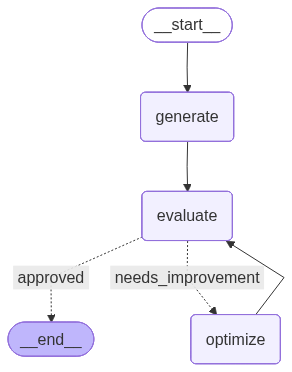

In [14]:
workflow

In [16]:

initial_state = {
    "topic": "srhberhb",
    "iteration": 1,
    "max_iterations": 5
}
result = workflow.invoke(initial_state)

In [17]:
result

{'topic': 'srhberhb',
 'tweet': 'My internal monologue when I\'m trying to adult but my brain just wants to keyboard mash: "srhberhb". It\'s a whole mood.',
 'evaluation': 'approved',
 'feedback': "This tweet effectively captures a highly relatable modern struggle with a touch of absurd humor. The 'srhberhb' perfectly translates the internal chaos into text, which is both original in its execution and genuinely funny, prompting a mild chuckle. It's punchy, well-formatted, and avoids common pitfalls like setup-punchline structures or excessive length. Its strong relatability ensures high virality potential, as many users will identify with the sentiment and be inclined to share it as 'a whole mood' itself.",
 'iteration': 1,
 'max_iterations': 5}